# Import Bonn data

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

os.chdir('/content/drive/My Drive/0-Project')
folders = ['F', 'O', 'S']
# O: healthy people with eyes closed; F: patients seizure free; S: seizure
dataframes = {}

for folder_path in folders:
  file_list = os.listdir(folder_path)
  data_dict = {}

  for file_name in file_list:
    column_name = file_name[1:4]
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r') as file:
      file_data = [line.strip() for line in file.readlines()]
      data_dict[column_name] = file_data

  df = pd.DataFrame(data_dict)
  df = df[sorted(df.columns)]

  # Store the DataFrame in the dictionary with the folder name as the key
  dataframes[folder_path] = df

# Accessing the DataFrames for F, O, and S
df_F = dataframes['F']
df_O = dataframes['O']
df_S = dataframes['S']
df_F = df_F.apply(pd.to_numeric)
df_O = df_O.apply(pd.to_numeric)
df_S = df_S.apply(pd.to_numeric)

# Representation 1

We start with separating 12 bits into 2 parts. We have two ways of representation.

Representation 1:

1. if nibble 1 and 2 are all same, we use 00 as prefix

2. if nibble 1 is the same and nibble 2 is different, we use 01

3. if nibble 1 is different and nibble 2 is the same, we use 10

4. if nibble 1 and 2 are different, we use 11

Representation 2, we don't consider condition 3:

1. if nibble 1 and 2 are all same, we use 00 as prefix

2. if nibble 1 is the same and nibble 2 is different, we use 01

3. if nibble 1 and 2 are different, we use 11

Intuitively, representation 1 might give us better compression ratio. So, we try it first.

In [ ]:
def compare(str1, str2, split):
  '''
  Params:
    str1  : input string 1
    str2  : input string 2
    split : an integer, we split the 12 bits into 0-(split-1) and split-12

  Compare str1 and str2, both are 12-bit binary representation, separate them
  in 2 nibbles, nibble 1, 2 using split
  if nibble 1 and 2 are all same, we use 00 as prefix
  if nibble 1 is the same and nibble 2 is different, we use 01
  if nibble 1 is different and nibble 2 is the same, we use 10
  if nibble 1 and 2 are different, we use 11
  '''
  # Ensure both strings are 12-bit binary representations
  if len(str1) != 12 or len(str2) != 12:
    raise ValueError("Both strings must be 12-bit binary representations.")

  # Split the strings into 2 nibbles
  nibbles1 = [str1[:split], str1[split:]]
  nibbles2 = [str2[:split], str2[split:]]

  # Compare the nibbles
  if nibbles1 == nibbles2:
    return '00'
  elif nibbles1[0] == nibbles2[0] and nibbles1[1] != nibbles2[1]:
    return '01'
  elif nibbles1[0] != nibbles2[0] and nibbles1[1] == nibbles2[1]:
    return '10'
  else:
    return '11'

In [ ]:
def l2sb(input, split):
  '''
  Params:
    input : a list of 12-bit binary string
    split : an integer, we split the 12 bits into 0-(split-1) and split-12
  Use L2SB algorithm and return a list of compressed result.
  '''
  res = []
  res.append(input[0])
  for i in range(1, len(input)):
    code = compare(input[i], input[i-1], split)
    if code == '11':
      res.append('11' + input[i])
    elif code == '10':
      res.append('10' + input[i][:split])
    elif code == '01':
      res.append('01' + input[i][split:])
    else:
      res.append('00')
  return res


In [ ]:
def total_length(strings):
  '''
  Params:
    strings : a list of string
  Return the total length of all strings in input string.
  '''
  return sum(len(s) for s in strings)

In [ ]:
def calRatio_all(input, split):
  '''
  Params:
    input : a data frame, each column represents a txt file
    split : an integer, we split the 12 bits into 0-(split-1) and split-12

  Use new l2sb algorithm to compress the input data. Record the length of compressed
  and original data of each column, then sum the compressed and original length
  of all data to get the overall compress ratio.
  '''
  original_length = 0
  compressed_length = 0
  for i in range(input.shape[1]):
    col = input.iloc[:,i]
    binarycol = [np.binary_repr(val, width=12) for val in col]
    col_compressed = l2sb(binarycol, split)
    original_length += total_length(binarycol)
    compressed_length += total_length(col_compressed)
  return original_length / compressed_length

# Test case

In [ ]:
split = 6
input = ['000011001001', '000011111001', '000100111001', '010100101001', '010100101001']
#            1-2             1 same           2 same      all different    all same
#            none             01                10            11              00
res = l2sb(input, split)
print(res)

['000011001001', '01111001', '10000100', '11010100101001', '00']


# Get compression ratio

## Transfer data to given range

Let's assume the data set has a range of [min, max], then for every data point in it, we use the following equation to transfer it into our desired range:

4095 * data[i] / (max - min)

We use 4095 because 2^12 = 4096, a 12 bit binary number is in range [0,4095]

In [ ]:
def transfer(data):
  '''
  Params:
    data : input data frame
  First we add offset to input data frame so we have a dataset of non-negative numbers.
  Transfer the data using following equation:
  new_data = 4095 * data[i] / (max - min)
  '''
  new_data = data.copy()
  min = data.min().min()
  if min < 0:
    new_data -= min
  min = new_data.min().min()
  max = new_data.max().max()
  new_data = 4095 * new_data / (max - min)
  new_data = new_data.round().astype(int)
  return new_data

In [ ]:
# df_F_new = transfer(df_F)
# df_O_new = transfer(df_O)
# df_S_new = transfer(df_S)

# if we only add offset to Bonn data but not scale it, what about the result?
f_temp = df_F.copy()
o_temp = df_O.copy()
s_temp = df_S.copy()
f_temp -= f_temp.min().min()
o_temp -= o_temp.min().min()
s_temp -= s_temp.min().min()

split_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ratio_list_f = {}
ratio_list_o = {}
ratio_list_s = {}
for split in split_list:
  ratio_f = calRatio_all(f_temp, split)
  ratio_o = calRatio_all(o_temp, split)
  ratio_s = calRatio_all(s_temp, split)
  ratio_list_f[split] = ratio_f
  ratio_list_o[split] = ratio_o
  ratio_list_s[split] = ratio_s



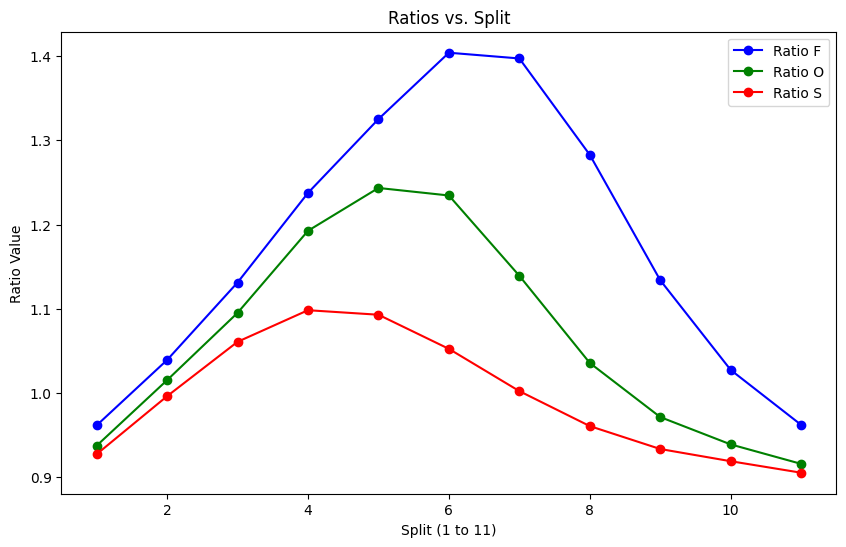

In [ ]:
x = list(ratio_list_f.keys())
plt.figure(figsize=(10, 6))
plt.plot(x, list(ratio_list_f.values()), marker='o', color='blue', label='Ratio F')
plt.plot(x, list(ratio_list_o.values()), marker='o', color='green', label='Ratio O')
plt.plot(x, list(ratio_list_s.values()), marker='o', color='red', label='Ratio S')

plt.xlabel('Split (1 to 11)')
plt.ylabel('Ratio Value')
plt.title('Ratios vs. Split')
plt.legend()

In [ ]:
import openpyxl
from openpyxl import Workbook

wb = Workbook()
ws_o = wb.active
ws_f = wb.create_sheet(title='Ratio List F')
ws_s = wb.create_sheet(title='Ratio List S')

ws_o.append(['Key', 'Value'])
ws_f.append(['Key', 'Value'])
ws_s.append(['Key', 'Value'])

for key, value in ratio_list_o.items():
  ws_o.append([str(key), value])

for key, value in ratio_list_f.items():
  ws_f.append([str(key), value])

for key, value in ratio_list_s.items():
  ws_s.append([str(key), value])

wb.save('2 nibbles.xlsx')


# Import MIT data

In [ ]:
os.chdir('/content/drive/My Drive/0-Project/MIT')
# 48 csv files
csv_files = [f for f in os.listdir() if f.endswith('.csv')]

df_mix = pd.DataFrame()

for file in csv_files:
  file_path = os.path.join(os.getcwd(), file)

  df = pd.read_csv(file_path, skiprows=1)

  df_last_two_cols = df.iloc[:, -2:]

  file_prefix = file[:3]
  df_last_two_cols.columns = [f"{file_prefix}-1", f"{file_prefix}-2"]

  df_mix = pd.concat([df_mix, df_last_two_cols], axis=1)


In [ ]:
# scale the data
#df_mix_scaled = transfer(df_mix)
df_mix_scaled = df_mix.mul(600)
# round the scaled result into integers
df_mix_scaled = df_mix_scaled.round().astype(int)
scaled_min = df_mix_scaled.min().min()
# add offset to all data, make them non-negative
df_mix_scaled = df_mix_scaled.add(abs(scaled_min))


# choose 1,3,5.. columns in df_mixed_scaled as mixed_signal_1
mixed_signal_1 = df_mix_scaled.iloc[:,1::2]
# choose 0,2,4.. columns in df_mixed_scaled as mixed_signal_2
mixed_signal_2 = df_mix_scaled.iloc[:,::2]

In [ ]:
split_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
mit_ratio_list = {}
for split in split_list:
  ratio_1 = calRatio_all(mixed_signal_1, split)
  ratio_2 = calRatio_all(mixed_signal_2, split)
  mit_ratio_list[split] = (ratio_1, ratio_2)
print(mit_ratio_list)

{1: (1.03306701235087, 1.0348859783829807), 2: (1.113973882641648, 1.117556896451369), 3: (1.2056493883666695, 1.2103319482457016), 4: (1.3057572712091101, 1.3033115779523126), 5: (1.4041949783235526, 1.3912595407555313), 6: (1.4632411468829916, 1.4432412793732592), 7: (1.43919345200294, 1.4235842936142606), 8: (1.3020839874312726, 1.2938909577388855), 9: (1.1296443385402877, 1.129009601155144), 10: (1.031167761685673, 1.0318512414460248), 11: (0.9925097487183193, 0.9931709915137907)}


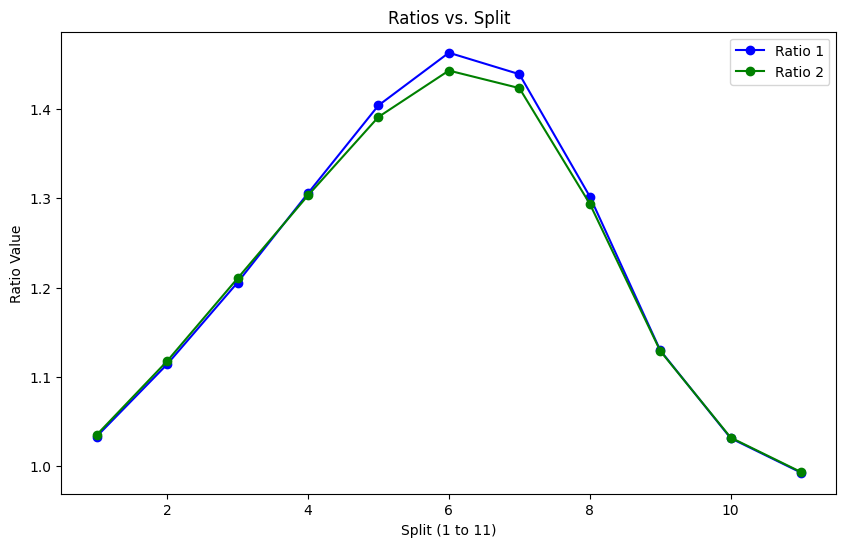

In [ ]:
x = list(mit_ratio_list.keys())
ratio_1 = [val[0] for val in mit_ratio_list.values()]
ratio_2 = [val[1] for val in mit_ratio_list.values()]

plt.figure(figsize=(10, 6))
plt.plot(x, ratio_1, marker='o', color='blue', label='Ratio 1')
plt.plot(x, ratio_2, marker='o', color='green', label='Ratio 2')

plt.xlabel('Split (1 to 11)')
plt.ylabel('Ratio Value')
plt.title('Ratios vs. Split')
plt.legend()

The results show that for mixed data, a split of 6 is best for compression ratio.

In [ ]:
import openpyxl
from openpyxl import Workbook

wb = Workbook()
ws_1 = wb.active
ws_1.title = 'Ratio List 1'
ws_2 = wb.create_sheet(title='Ratio List 2')

ws_1.append(['Key', 'Value'])
ws_2.append(['Key', 'Value'])

for key, value in zip(x, ratio_1):
  ws_1.append([str(key), value])

for key, value in zip(x, ratio_2):
  ws_2.append([str(key), value])

wb.save('2 nibbles MIT.xlsx')